## Differential protein abundance with label-free proteomics (proDA)

This notebook demonstrates a **first-pass** protein-level differential abundance workflow for **label-free quantification (LFQ)** proteomics.
“First-pass” here means: a reproducible, broadly applicable baseline analysis that produces (1) QC diagnostics and (2) a ranked list of candidate proteins—before adding study-specific refinements like batch covariates, peptide-level modeling, or complex random effects.

The example dataset (UbiLength) contains **MaxQuant proteinGroups output with LFQ intensities**, and has 4 conditions × 3 replicates (12 samples).
LFQ remains widely used in quantitative proteomics and is directly supported by tools like MaxQuant/MaxLFQ.

We use **proDA**, which is specifically designed for label-free MS data with many missing values. Instead of imputing missing values and then using a standard linear model, proDA fits a **probabilistic dropout model** and supports **full linear-model designs + moderated inference**, producing effect sizes (log2 fold-changes) and FDRs.

In [ ]:
## Paths
data_dir <- "data"
downloader <- file.path(data_dir, "downloaders", "download_ubilength.R")

## Packages
suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(ggplot2)
  library(proDA)
})

## Download dataset (creates ds_dir with proteinGroups.tsv + experimental_design.csv)
source(downloader)
ds_dir <- download_if_missing(data_dir)

[1] "data/ubilength_ubiquitin_interactors"

In [ ]:
## Load the analysis input files
# The downloader materializes two files:
# - proteinGroups.tsv: a MaxQuant-style table containing protein metadata + LFQ intensity columns.
# - experimental_design.csv: a minimal sample sheet mapping each LFQ column label -> condition/replicate.

protein_groups <- readr::read_tsv(file.path(ds_dir, "proteinGroups.tsv"), show_col_types = FALSE)
samples <- readr::read_csv(file.path(ds_dir, "experimental_design.csv"), show_col_types = FALSE)

protein_groups %>% dplyr::glimpse()
samples


Rows: 3,006
Columns: 23
$ Protein.IDs             <chr> "A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9;D6REZ6;D…
$ Majority.protein.IDs    <chr> "A0AV96-2;B7Z8Z7;A0AV96;D6R9D6;D6RBS9", "A0AVT…
$ Protein.names           <chr> "RNA-binding protein 47", "Ubiquitin-like modi…
$ Gene.names              <chr> "RBM47", "UBA6", "ILVBL", "FAM92A1", "ACO2", "…
$ Fasta.headers           <chr> ">sp|A0AV96-2|RBM47_HUMAN Isoform 2 of RNA-bin…
$ Peptides                <dbl> 7, 6, 5, 1, 10, 1, 1, 2, 2, 1, 4, 1, 2, 7, 12,…
$ Razor...unique.peptides <dbl> 7, 6, 5, 1, 10, 1, 1, 2, 2, 1, 4, 1, 1, 7, 12,…
$ Unique.peptides         <dbl> 7, 6, 5, 1, 10, 1, 1, 2, 2, 1, 4, 1, 1, 6, 12,…
$ LFQ.intensity.Ubi4_1    <dbl> 35787000, 0, 0, 0, 26040000, 0, 0, 0, 0, 0, 36…
$ LFQ.intensity.Ubi4_2    <dbl> 24701000, 0, 0, 0, 21259000, 0, 0, 0, 0, 0, 33…
$ LFQ.intensity.Ubi4_3    <dbl> 29855000, 0, 0, 0, 24578000, 0, 0, 0, 0, 0, 33…
$ LFQ.intensity.Ubi6_1    <dbl> 28313000, 0, 0, 0, 16447000, 0, 0, 0, 0, 0, 0,…
$ LFQ.intensity.

label,condition,replicate
<chr>,<chr>,<dbl>
Ubi4_1,Ubi4,1
Ubi4_2,Ubi4,2
Ubi4_3,Ubi4,3
Ubi6_1,Ubi6,1
Ubi6_2,Ubi6,2
Ubi6_3,Ubi6,3
Ctrl_1,Ctrl,1
Ctrl_2,Ctrl,2
Ctrl_3,Ctrl,3


In [ ]:
## Minimal MaxQuant-specific cleaning
##
## MaxQuant proteinGroups tables typically include flags:
## - Reverse == "+" : decoy (“reverse”) hits used for FDR control; remove for downstream quant.
## - Potential.contaminant == "+" : common contaminants (keratins, trypsin, etc.); remove by default.
## - Only.identified.by.site == "+" : protein group inferred only from modified peptides; often unreliable for quant.
##
## These filters reduce obvious technical artifacts before modeling.

clean <- protein_groups %>%
  filter(
    is.na(Reverse) | Reverse != "+",
    is.na(Potential.contaminant) | Potential.contaminant != "+",
    is.na(Only.identified.by.site) | Only.identified.by.site != "+"
  )

# Use Gene.names when available (nice for plots), else fall back to Protein.IDs
prot_name <- clean[["Gene.names"]]
prot_name[is.na(prot_name) | prot_name == ""] <- clean[["Protein.IDs"]][is.na(prot_name) | prot_name == ""]
prot_name <- make.unique(prot_name)

# Extract LFQ columns
lfq_cols <- grep("^LFQ\\.intensity\\.", colnames(clean), value = TRUE)
stopifnot(length(lfq_cols) > 0)

lfq_mat <- as.matrix(clean[, lfq_cols])
colnames(lfq_mat) <- sub("^LFQ\\.intensity\\.", "", colnames(lfq_mat))
rownames(lfq_mat) <- prot_name

# Reorder columns to match sample table and verify labels match
lfq_mat <- lfq_mat[, samples$label, drop = FALSE]

dim(lfq_mat)
head(colnames(lfq_mat))

[1] 2907   12

[1] "Ubi4_1" "Ubi4_2" "Ubi4_3" "Ubi6_1" "Ubi6_2" "Ubi6_3"

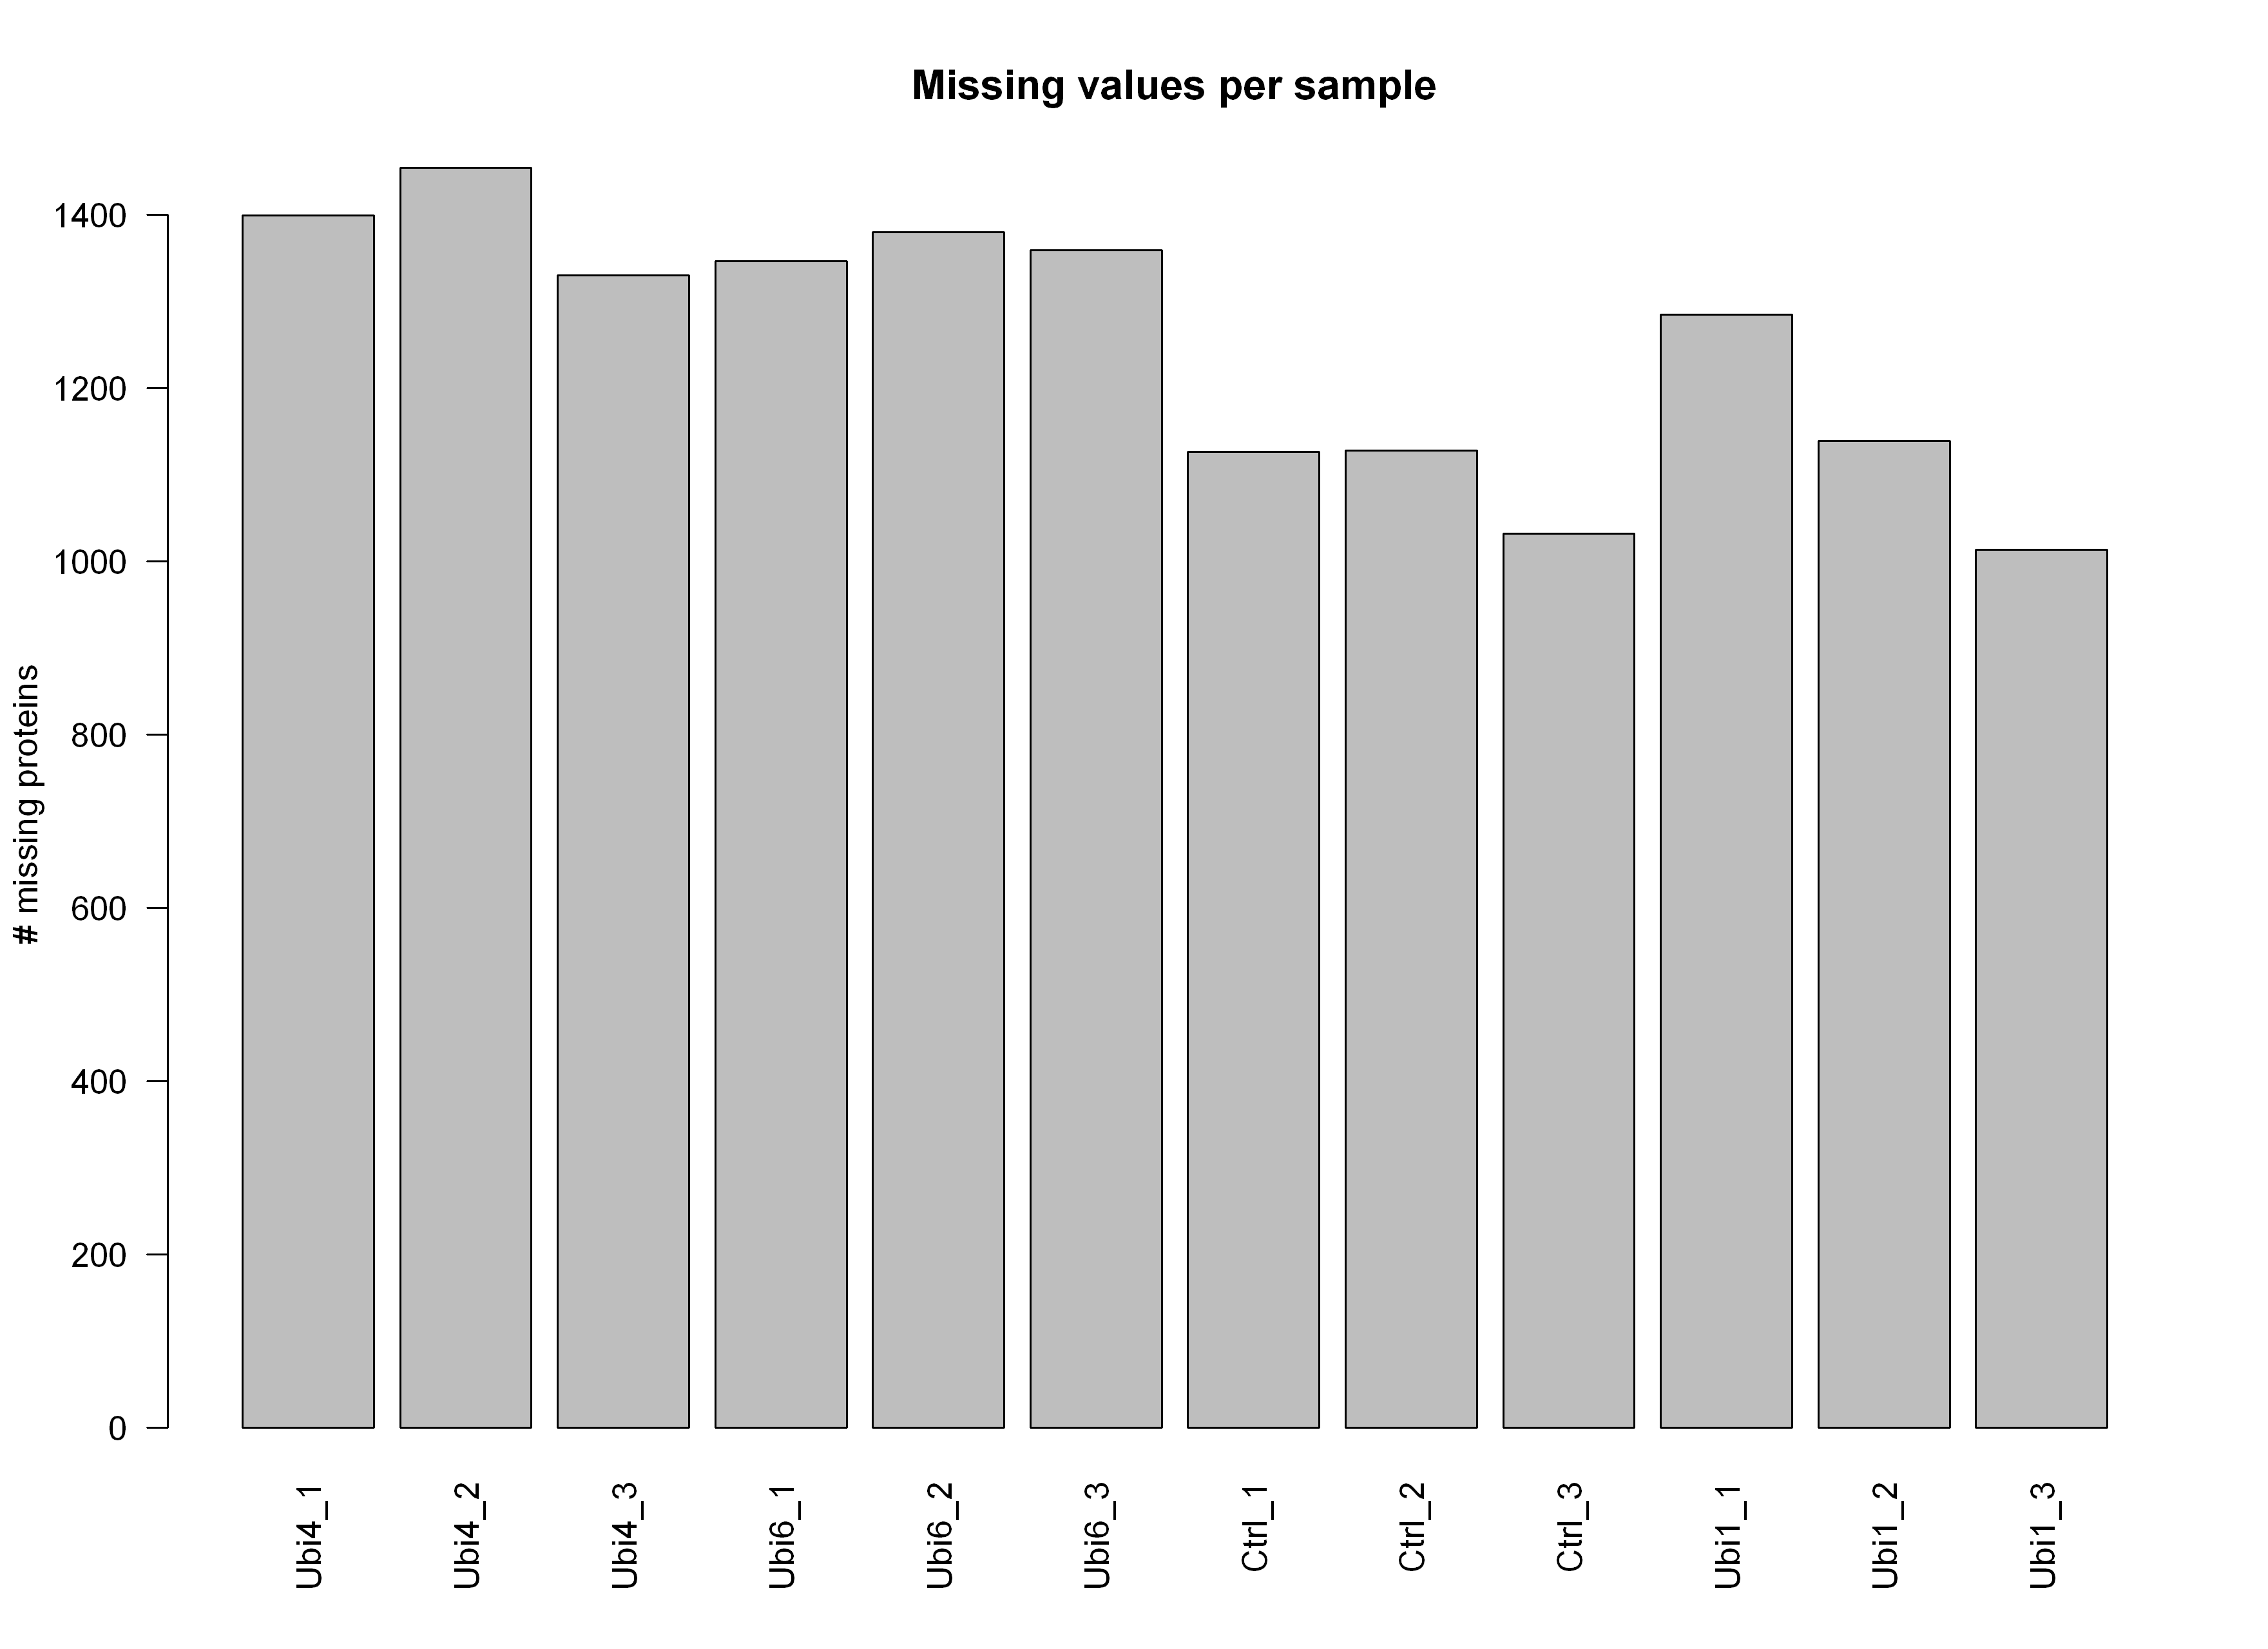

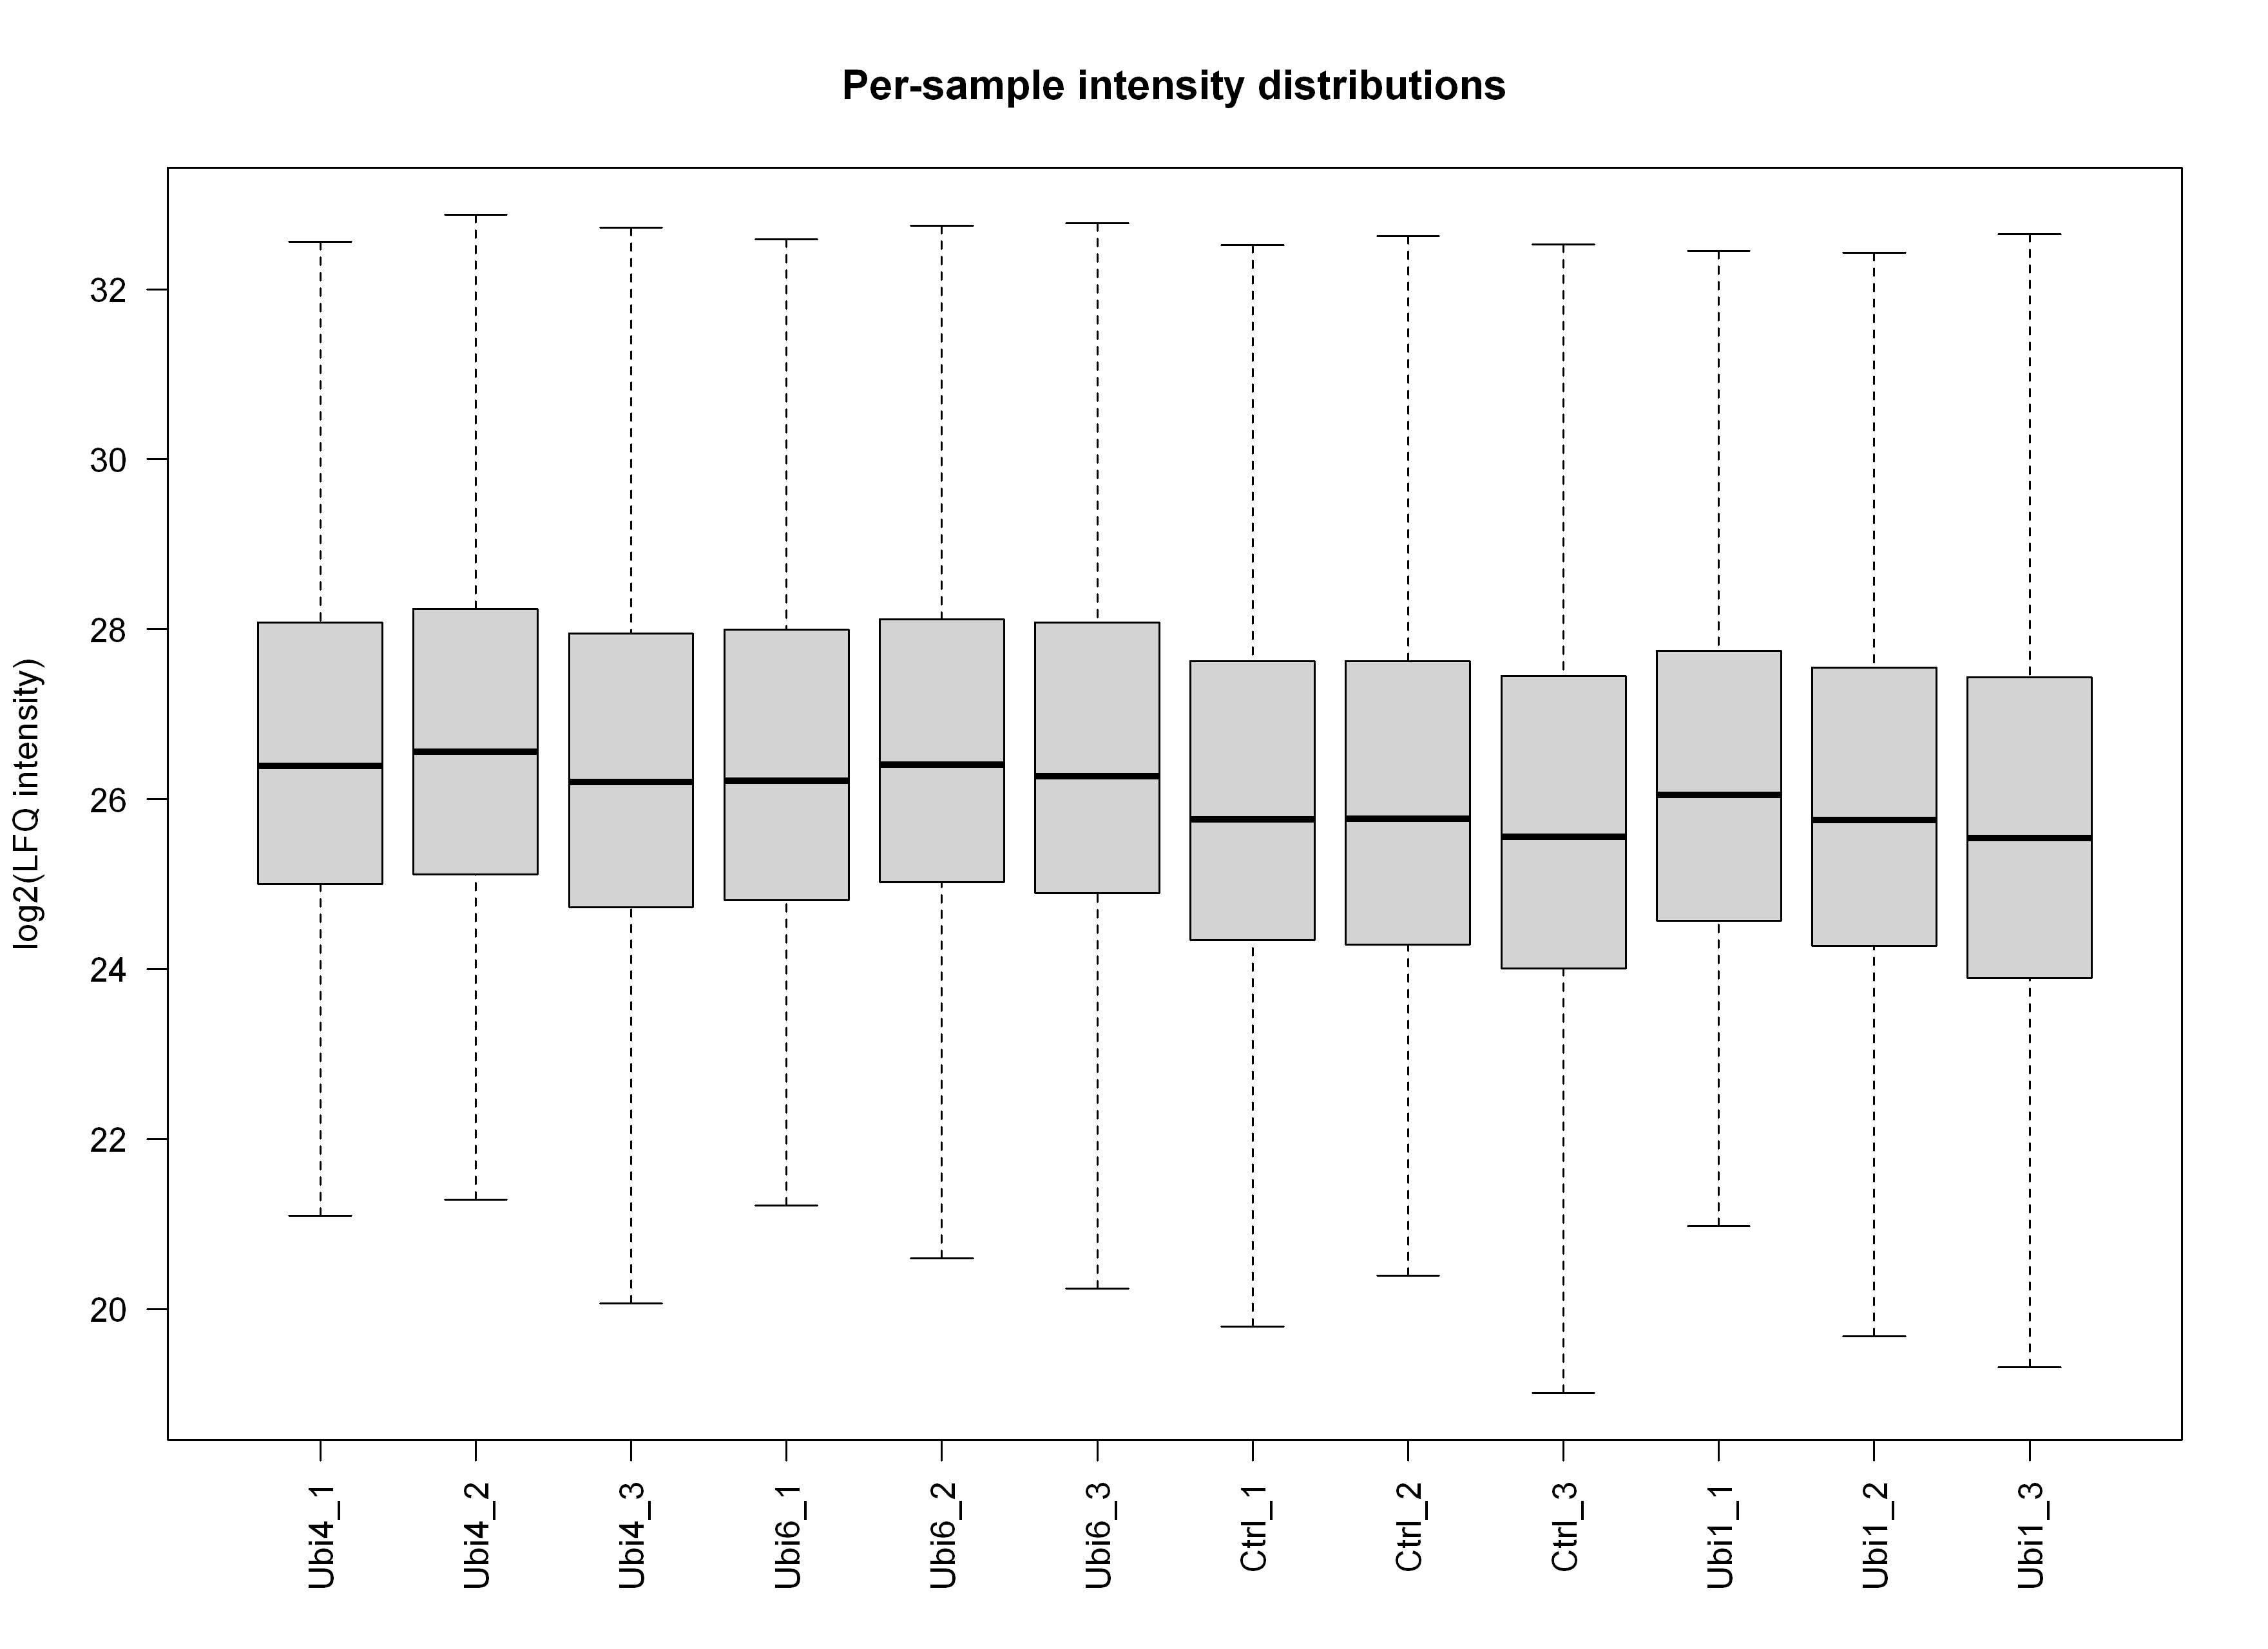

In [ ]:
## Transform for proDA
## - MaxQuant LFQ has zeros for "missing": convert 0 -> NA for log2 transform
## - log2 transform makes fold-changes additive and stabilizes variance
Y[Y == 0] <- NA
log2Y <- log2(Y)

## QC 1: missingness per sample (big differences can indicate outliers or swaps)
## - A sample with far more missing values than others can indicate poor LC-MS run quality,
##   sample loss, or a mismatch between sample labels and intensity columns.
## - If *all* samples have extremely high missingness, upstream processing/thresholds may be too strict.

barplot(colSums(is.na(log2Y)),
        las = 2, ylab = "# missing proteins", main = "Missing values per sample")

## QC 2: intensity distribution per sample (post log2)
## - Strong shifts in median across samples suggest global intensity differences (loading/instrument drift).
## - Very wide/narrow boxes can indicate variance differences or artifacts.
## - Outliers aren't necessarily “bad” here; focus on systematic shifts.
boxplot(log2Y, las = 2, outline = FALSE,
        ylab = "log2(LFQ intensity)", main = "Per-sample intensity distributions")

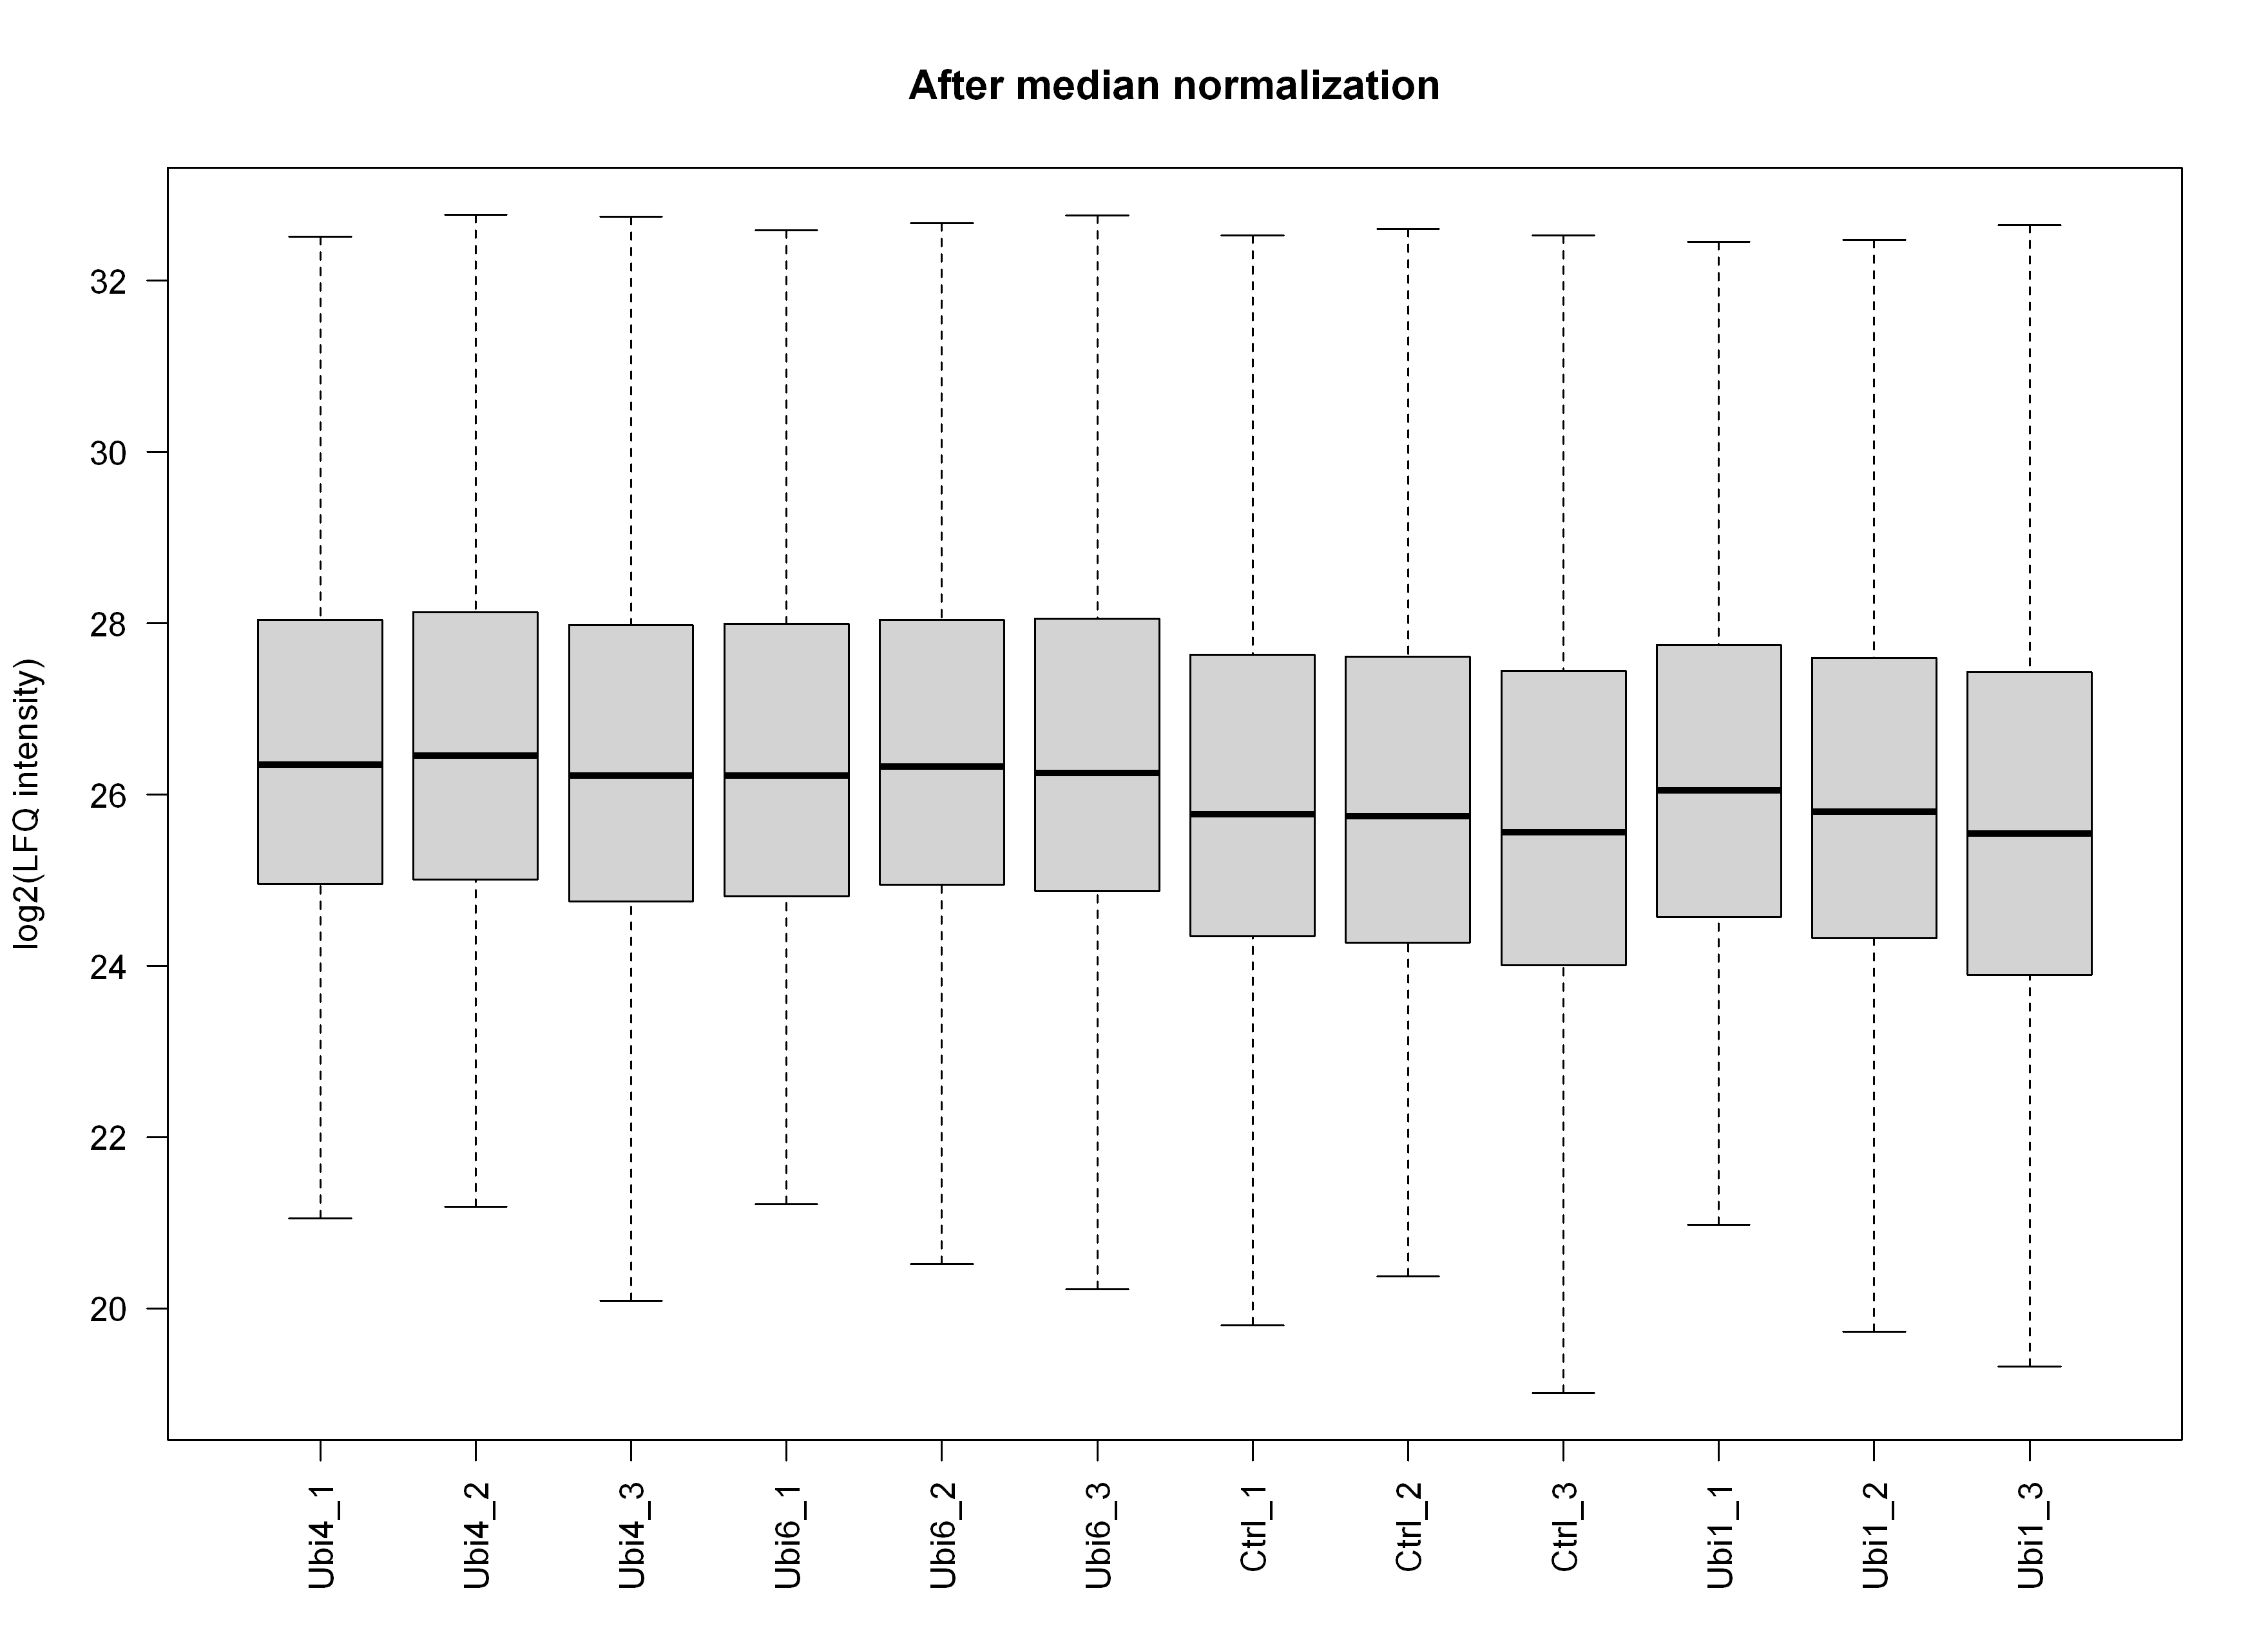

In [ ]:
## Normalization
## proDA recommends conservative median normalization for LFQ (and provides a helper).
## In log2 space, median normalization applies a *per-sample shift* so that each sample has the same median.
## It's "conservative" in the sense that it does not reshape distributions or force samples to look identical—
## it only corrects global offsets that often reflect technical loading/instrument differences.
##
## proDA explicitly provides median_normalization() as a helpful QC/normalization step for LFQ workflows. :contentReference[oaicite:3]{index=3}
norm_log2Y <- proDA::median_normalization(log2Y)

boxplot(norm_log2Y, las = 2, outline = FALSE,
        ylab = "log2(LFQ intensity)", main = "After median normalization")

In [1]:
## QC 3: sample similarity without imputing missing values
## Why avoid imputation here?
## - Imputation fabricates values and can artificially increase similarity between samples.
## - proDA provides dist_approx(), which estimates expected distances while accounting for missingness. :contentReference[oaicite:4]{index=4}
##
## What to watch for:
## - Replicates within the same condition should be relatively close (low distances).
## - A sample that is far from *everything* is a candidate outlier.
## - If samples cluster by replicate/run-order instead of condition, consider batch covariates.

da <- proDA::dist_approx(norm_log2Y)
dist_mat <- as.matrix(da$mean)

# Simple sample annotation (what pheatmap expects)
anno <- data.frame(
  condition = samples$condition,
  replicate = samples$replicate,
  row.names = samples$label
)


# Cluster using the distance matrix itself
hc <- hclust(as.dist(dist_mat), method = "average")
library(pheatmap)
pheatmap::pheatmap(
  dist_mat,
  cluster_rows = hc,
  cluster_cols = hc,
  annotation_row = anno,
  annotation_col = anno,
  main = "Sample distance (proDA::dist_approx mean)",
  border_color = NA
)

: 

In [ ]:
## Differential abundance with proDA (fixed contrasts) [what are fixed contrasts?]

samples <- samples %>%
  mutate(
    condition = factor(condition),
    replicate = factor(replicate)
  )

# Design without intercept [why no intercept?]
design <- model.matrix(~ 0 + condition, data = samples)

# make the design column names match the condition levels exactly.
# This avoids surprises from model.matrix() name munging.
colnames(design) <- levels(samples$condition)

# these are the ONLY names you can use in test_diff() contrasts
print(colnames(design))
print(levels(samples$condition))

fit <- proDA::proDA(norm_log2Y, design = design)

# Test the contrast of interest (Ubi1 vs Ctrl) and sort by adjusted p-value.
res_1_vs_ctrl <- proDA::test_diff(fit, `Ubi1` - `Ctrl`, sort_by = "adj_pval")
head(res_1_vs_ctrl)


[1] "Ctrl" "Ubi1" "Ubi4" "Ubi6"
[1] "Ctrl" "Ubi1" "Ubi4" "Ubi6"


,name,pval,adj_pval,diff,t_statistic,se,df,avg_abundance,n_approx,n_obs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1613,RPS27A,6.049738e-11,1.758659e-07,7.292561,45.465321,0.1603983,8,33.62913,12.000000,12
1399,USP5,3.851213e-07,5.597738e-04,10.301719,15.001115,0.6867302,8,30.50694,9.033440,9
2895,USP3,7.250586e-06,7.025818e-03,7.311431,10.213027,0.7158926,8,27.03834,9.097152,9
2391,OTUB1,3.300097e-05,2.398346e-02,5.746495,8.316194,0.6910005,8,26.14820,9.042914,9
1607,RPL31,4.898294e-05,2.847868e-02,-6.369936,-7.873172,0.8090686,8,25.15258,6.073910,6
2027,PDE12,9.383185e-05,4.307067e-02,4.964196,7.184834,0.6909270,8,26.30768,9.042770,9


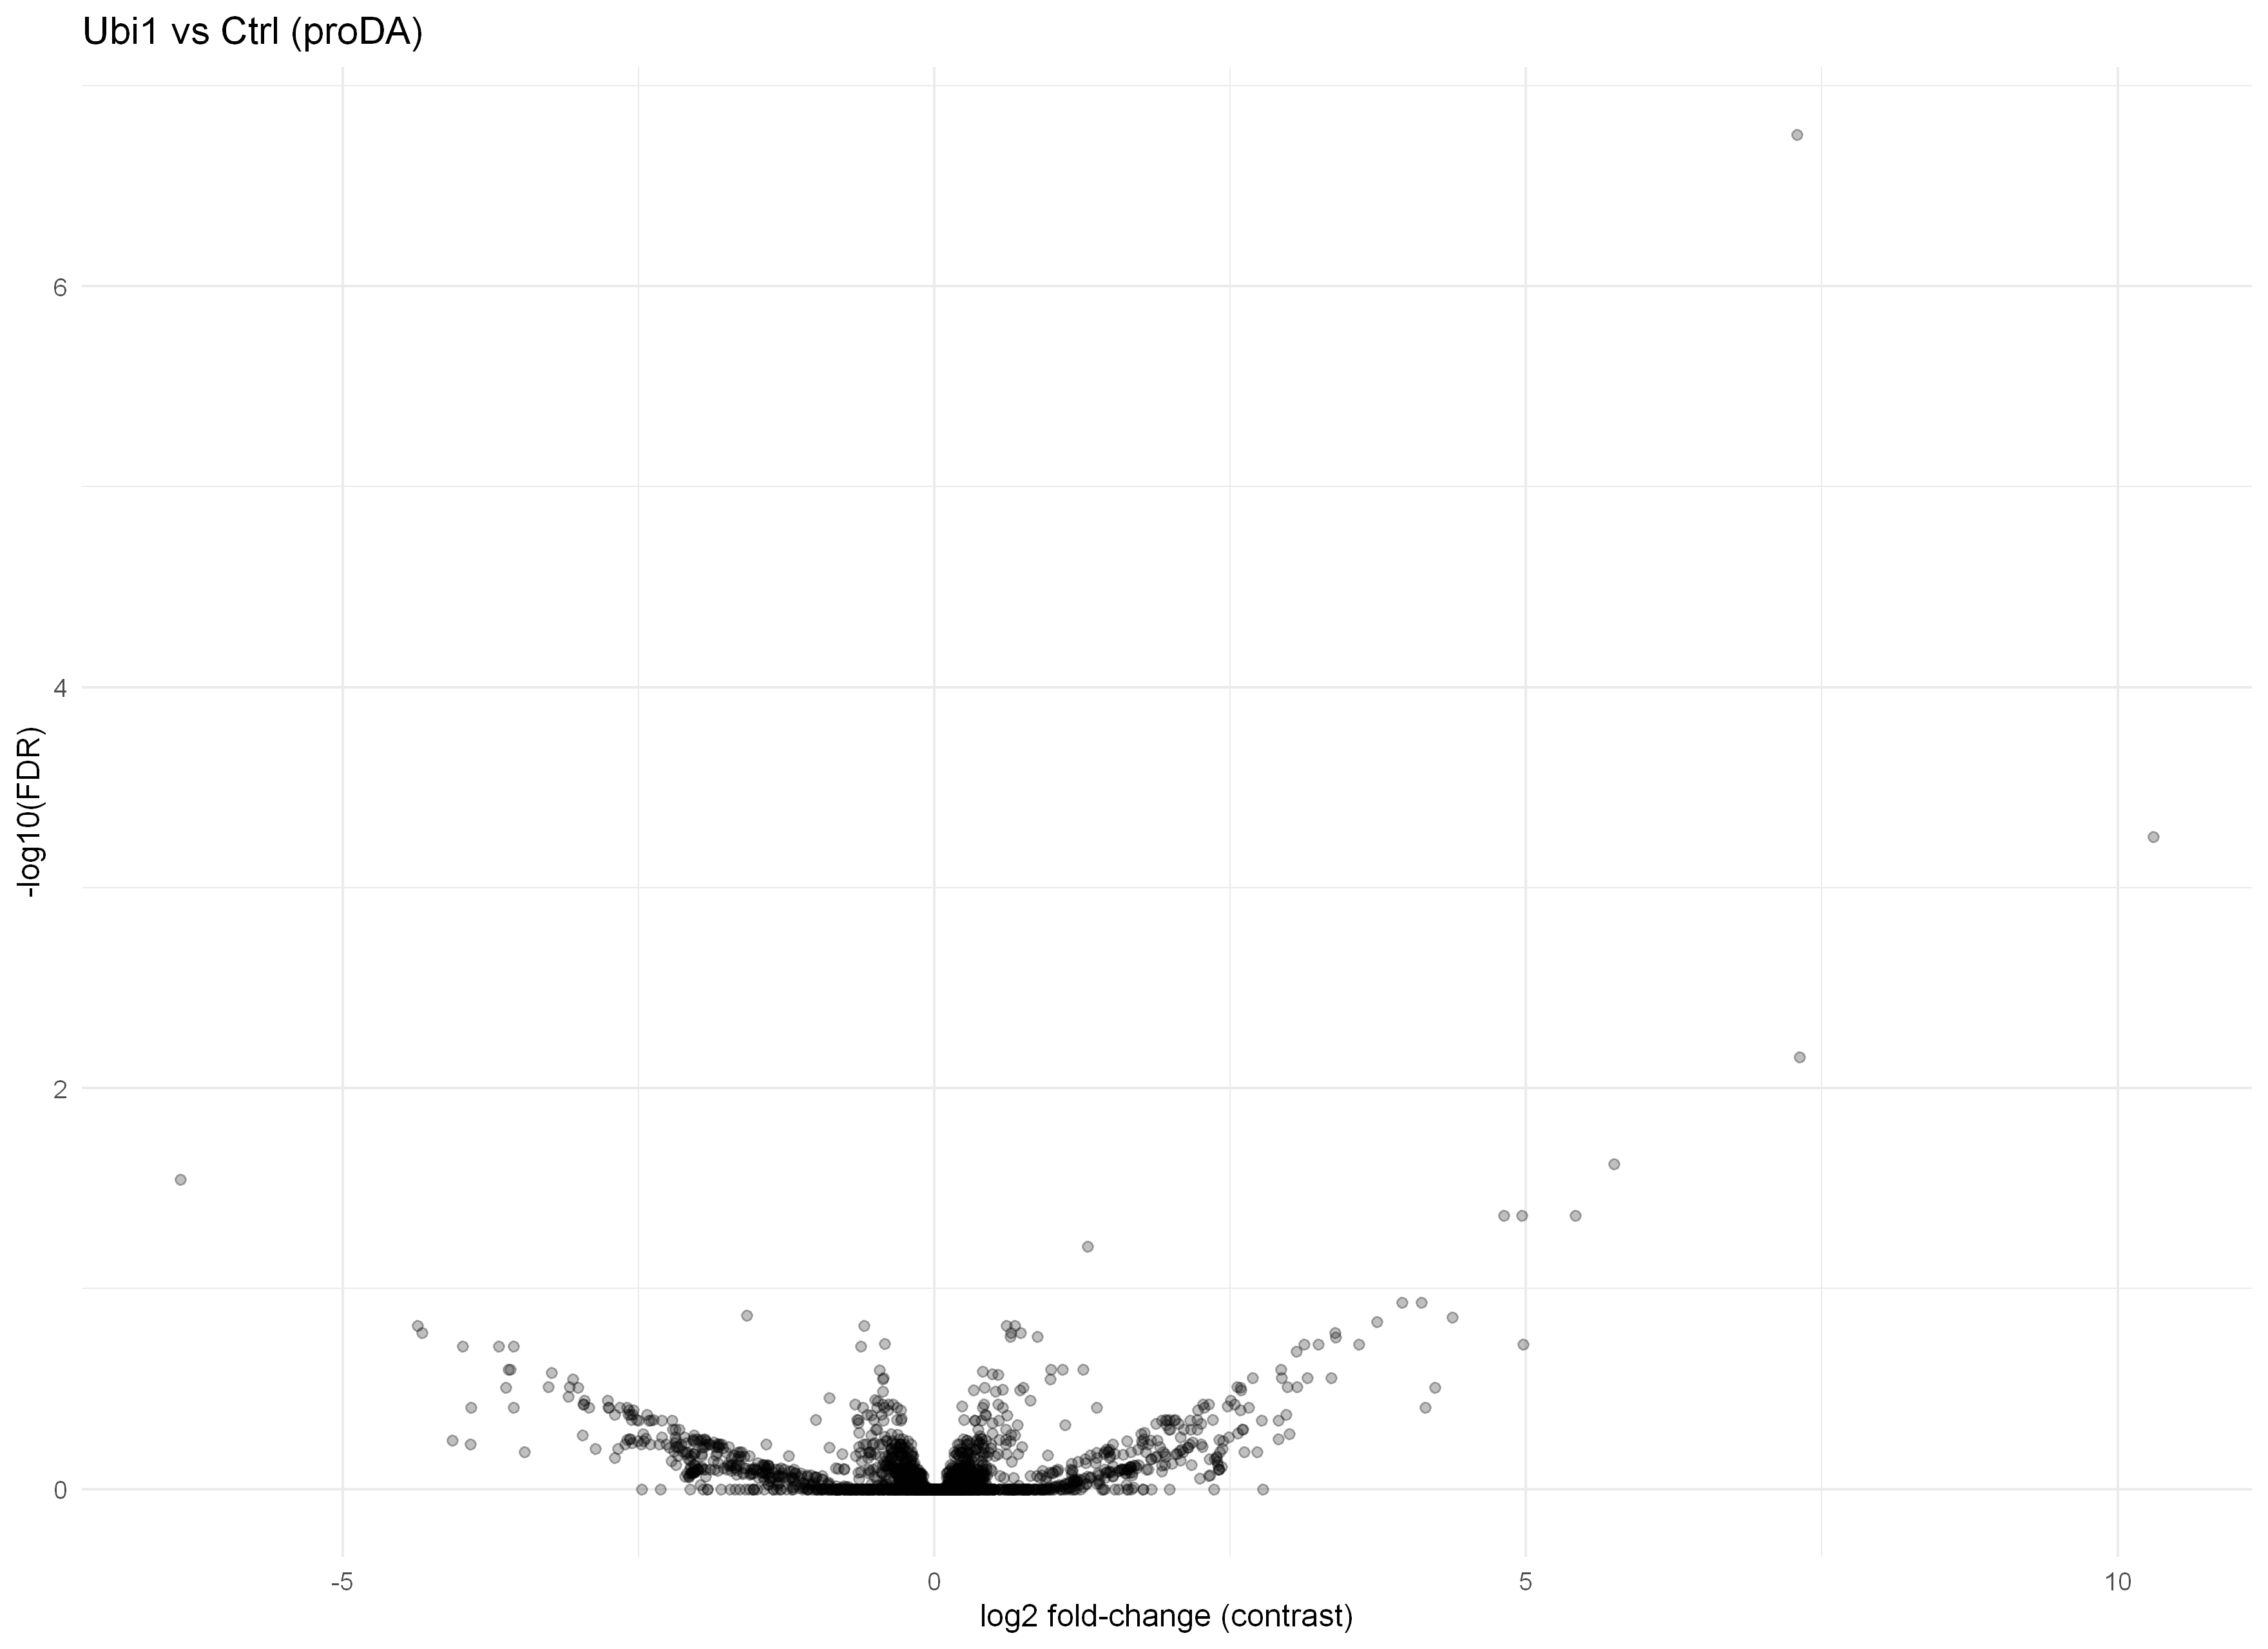

In [ ]:
## Volcano plot [looks bad, needs visual improvement]
## x: estimated difference (log2 fold-change), y: -log10(adjusted p)
plot_volcano <- function(res, title) {
  res <- res %>% mutate(neglog10_fdr = -log10(adj_pval))
  ggplot(res, aes(x = diff, y = neglog10_fdr)) +
    geom_point(alpha = 0.25) +
    labs(title = title, x = "log2 fold-change (contrast)", y = "-log10(FDR)") +
    theme_minimal()
}

plot_volcano(res_1_vs_ctrl, "Ubi1 vs Ctrl (proDA)")


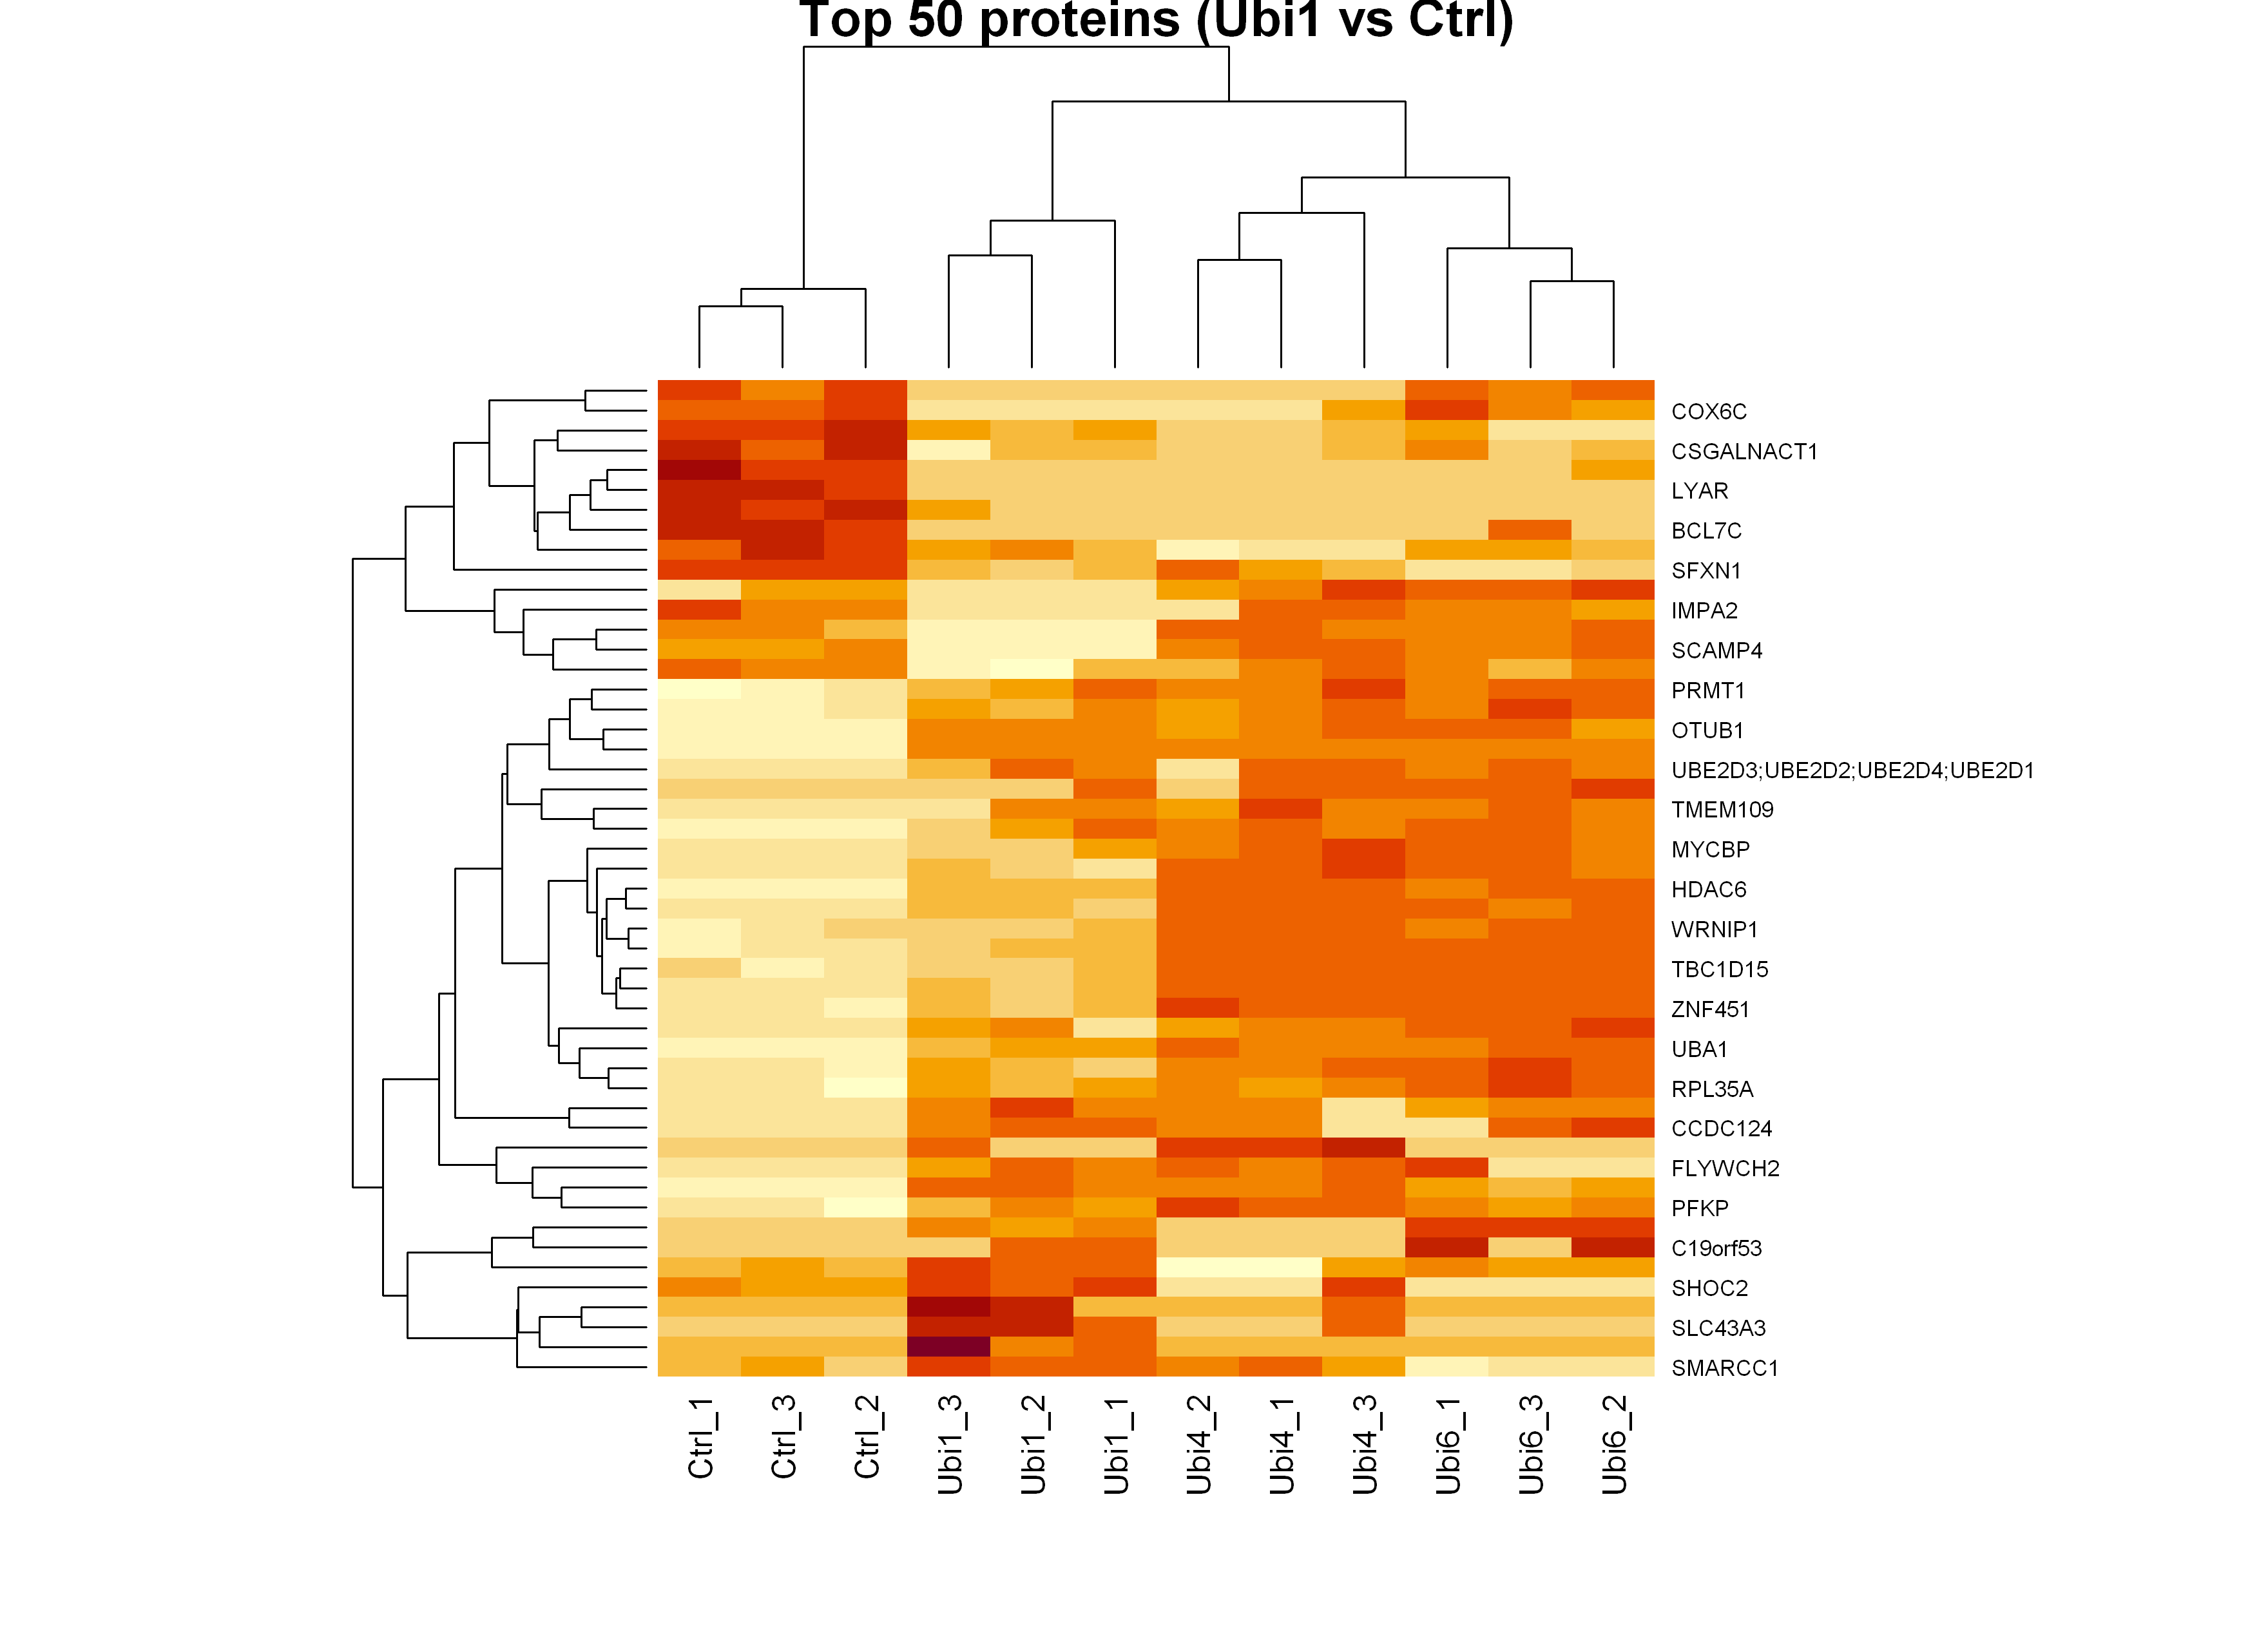

In [ ]:
## Heatmap of top hits (visualization-only imputation)
## For heatmaps, we need a complete matrix. We do a minimal, explicit imputation:
## - per protein, replace NA with (row min - 1), which keeps missing values low.
top_n <- 50
top <- res_1_vs_ctrl %>%
  slice_head(n = top_n) %>%
  pull(name)

mat <- norm_log2Y[top, , drop = FALSE]

row_min <- apply(mat, 1, function(x) min(x, na.rm = TRUE))
mat_imp <- mat
for (i in seq_len(nrow(mat_imp))) {
  mat_imp[i, is.na(mat_imp[i, ])] <- row_min[i] - 1
}

# z-score per protein for comparability
mat_z <- t(scale(t(mat_imp)))
# [missing a legend and an explanation of what to look for here]
heatmap(mat_z, scale = "none", margins = c(8, 8),
        main = sprintf("Top %d proteins (Ubi1 vs Ctrl)", top_n))


In [ ]:
## Results table you can export
sig <- res_1_vs_ctrl %>% filter(adj_pval < 0.05)
nrow(sig)
sig %>% select(name, diff, pval, adj_pval, avg_abundance, n_obs) %>% head(20)

# write.csv(res_1_vs_ctrl, file.path(ds_dir, "results_ubi1_vs_ctrl_proDA.csv"), row.names = FALSE)


[1] 8

,name,diff,pval,adj_pval,avg_abundance,n_obs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,RPS27A,7.292561,6.049738e-11,1.758659e-07,33.62913,12
2,USP5,10.301719,3.851213e-07,5.597738e-04,30.50694,9
3,USP3,7.311431,7.250586e-06,7.025818e-03,27.03834,9
4,OTUB1,5.746495,3.300097e-05,2.398346e-02,26.14820,9
5,RPL31,-6.369936,4.898294e-05,2.847868e-02,25.15258,6
6,PDE12,4.964196,9.383185e-05,4.307067e-02,26.30768,9
7,TMEM109,5.418973,1.185295e-04,4.307067e-02,25.98608,8
8,HDAC6,4.813677,1.156819e-04,4.307067e-02,26.12533,9


## Additional considerations (when adapting to your own data)
 - Protein inference / rollup: If you have peptide-level quant, consider MSstats (more complex but very flexible).
 - Filtering: decide rules like "present in >= k replicates per condition" based on your design. [how would one design that? is there a rule of thumb that is different from what we did here?]
 - Batch effects: add covariates (e.g., run day) into the design matrix if needed.
 - Visualization: use the minimal imputation only for plots, not for inference. [why]
